This notebook is for building a neural network autoencoder for checking for anomaly in the accelerometer readings.  
The normal readings features are input  to the NN autoencoder for inferencing . Metric selected is MSE . The model is used for identifying a threshold of the metruc such that values predicted greater than the threshold can be marked as an anomaly.    


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers

In [3]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Python 3.8.3
Numpy 1.19.5
TensorFlow 2.4.1
Keras 2.4.0


In [4]:
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_curve,auc

In [5]:
from sklearn.model_selection import train_test_split

Read in the normal and anomaly data.   


In [16]:
normal_features_df  = pd.read_csv("normal_features_df.csv")

In [17]:
anomaly_features_df = pd.read_csv("anomaly_features_df.csv")

In [18]:
normal_features_df.shape

(201, 4)

In [19]:
normal_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mad_x    201 non-null    float64
 1   mad_y    201 non-null    float64
 2   mad_z    201 non-null    float64
 3   anomaly  201 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


In [20]:
normal_features_df.head()

,mad_x,mad_y,mad_z,anomaly
0,0.015381,0.011718,0.005860,0
1,0.015625,0.012939,0.006348,0
2,0.015137,0.011963,0.007080,0
3,0.014648,0.011963,0.006348,0
4,0.014160,0.011718,0.005859,0


In [21]:
anomaly_features_df.shape

(201, 4)

In [22]:
anomaly_features_df.head()

,mad_x,mad_y,mad_z,anomaly
0,0.011231,0.009033,0.005859,1
1,0.009766,0.009277,0.006347,1
2,0.011718,0.010253,0.006836,1
3,0.010254,0.009765,0.006347,1
4,0.010254,0.009521,0.006836,1


In [23]:
anomaly_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mad_x    201 non-null    float64
 1   mad_y    201 non-null    float64
 2   mad_z    201 non-null    float64
 3   anomaly  201 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


Split the features into train, validate and test sets.  

Select the first 175 records so that the remaining 25 records can be used for final testing later.  

In [25]:
normal_features = normal_features_df[['mad_x','mad_y','mad_z']][:175]
X_train_val, X_test, y_train_val, y_test  = train_test_split(normal_features, normal_features_df['anomaly'][:175], random_state = 1 , test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val , random_state = 1 , test_size = 0.2)

#
print("\n X_train : {}".format(X_train.shape))
print("\n X_val : {}".format(X_val.shape))
print("\n X_test : {}".format(X_test.shape))
#
print("\n y_train : {}".format(y_train.shape))
print("\n y_val : {}".format(y_val.shape))
print("\n y_test : {}".format(y_test.shape))


 X_train : (118, 3)

 X_val : (30, 3)

 X_test : (27, 3)

 y_train : (118,)

 y_val : (30,)

 y_test : (27,)


Create a neural network autoencoder.  

The below code is taken from https://github.com/ShawnHymel/tinyml-example-anomaly-detection/blob/master/autoencoder/anomaly-detection-training-autoencoder.ipynb

In [26]:
# Get input shape for 1 sample
sample_shape = X_train.shape[1:]
print(sample_shape)

(3,)


After couple of iterations, the model architecture as shown below was arrived at.

In [65]:
model = tf.keras.models.Sequential([
     layers.InputLayer(input_shape=sample_shape),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
     tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),    
tf.keras.layers.Dense(*sample_shape, activation=tf.nn.relu)])

# Display model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 63        
Total params: 563
Trainable params: 563
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Add training parameters to model
model.compile(optimizer='adam',
             loss='mse')

In [67]:
# Train model (note Y labels are same as inputs, X)
history = model.fit(X_train,
                   X_train,
                   epochs=50,
                   batch_size=80,
                   validation_data=(X_val, X_val),
                   verbose=0)

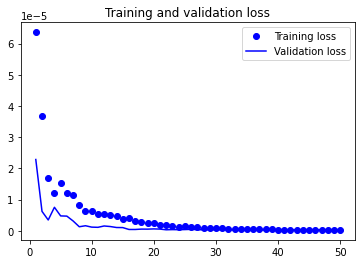

In [68]:
# Plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Average MSE for normal validation set: 2.9949606168185174e-07
Standard deviation of MSE for normal validation set: 3.6065386930170974e-07
Recommended threshold (3x std dev + avg): 1.381457669586981e-06


(array([9., 5., 6., 2., 3., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([1.49036203e-08, 9.16173850e-08, 1.68331150e-07, 2.45044915e-07,
        3.21758679e-07, 3.98472444e-07, 4.75186209e-07, 5.51899974e-07,
        6.28613738e-07, 7.05327503e-07, 7.82041268e-07, 8.58755033e-07,
        9.35468797e-07, 1.01218256e-06, 1.08889633e-06, 1.16561009e-06,
        1.24232386e-06, 1.31903762e-06, 1.39575139e-06, 1.47246515e-06,
        1.54917892e-06]),
 <a list of 20 Patch objects>)

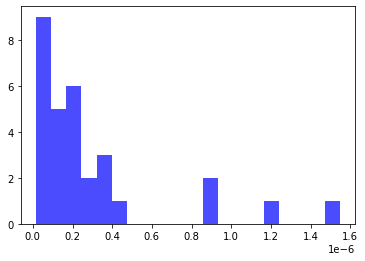

In [69]:
# Calculate MSE from validation set

predictions = model.predict(X_val)
normal_mse = np.mean(np.power(X_val - predictions, 2), axis=1)
print('Average MSE for normal validation set:', np.average(normal_mse))

print('Standard deviation of MSE for normal validation set:', np.std(normal_mse))

print('Recommended threshold (3x std dev + avg):', (3*np.std(normal_mse)) + np.average(normal_mse))
fig, ax = plt.subplots(1,1)
ax.hist(normal_mse, bins=20, label='normal', color='blue', alpha=0.7)

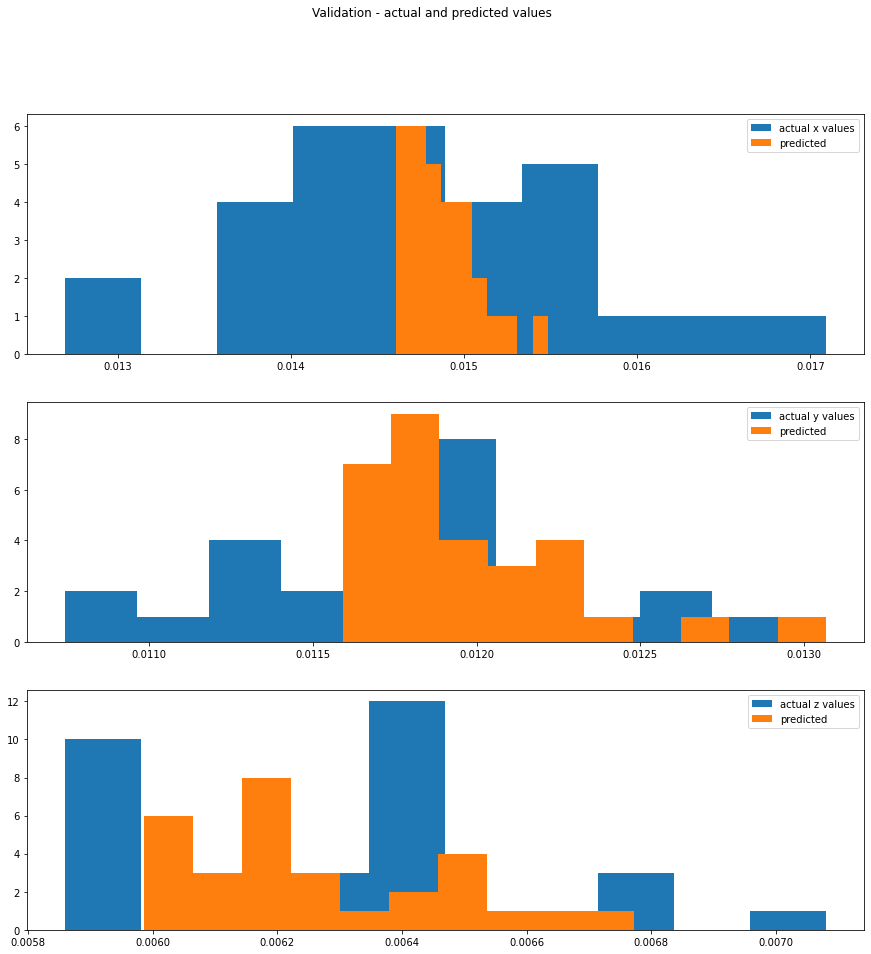

In [70]:
# plot actual Vs predicted values 
plt.figure(figsize = (15,15))
plt.suptitle("Validation - actual and predicted values")
plt.subplot(3,1,1)
plt.hist(X_val['mad_x'], label = 'actual x values')
plt.hist(predictions[:,0] , label = 'predicted')
plt.legend()
plt.subplot(3,1,2)
plt.hist(X_val['mad_y'], label = 'actual y values')
plt.hist(predictions[:,1] , label = 'predicted')
plt.legend()
##
plt.subplot(3,1,3)
plt.hist(X_val['mad_z'], label = 'actual z values')
plt.hist(predictions[:,2] , label = 'predicted')
plt.legend()

Check Average MSE for X_test data set.

In [71]:
pred_test = model.predict(X_test)
normal_mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
print('Average MSE for normal test set:', np.average(normal_mse_test))
print('Standard deviation of MSE for normal test set:', np.std(normal_mse_test))

Average MSE for normal test set: 2.6158883910409164e-07
Standard deviation of MSE for normal test set: 1.943046185314706e-07


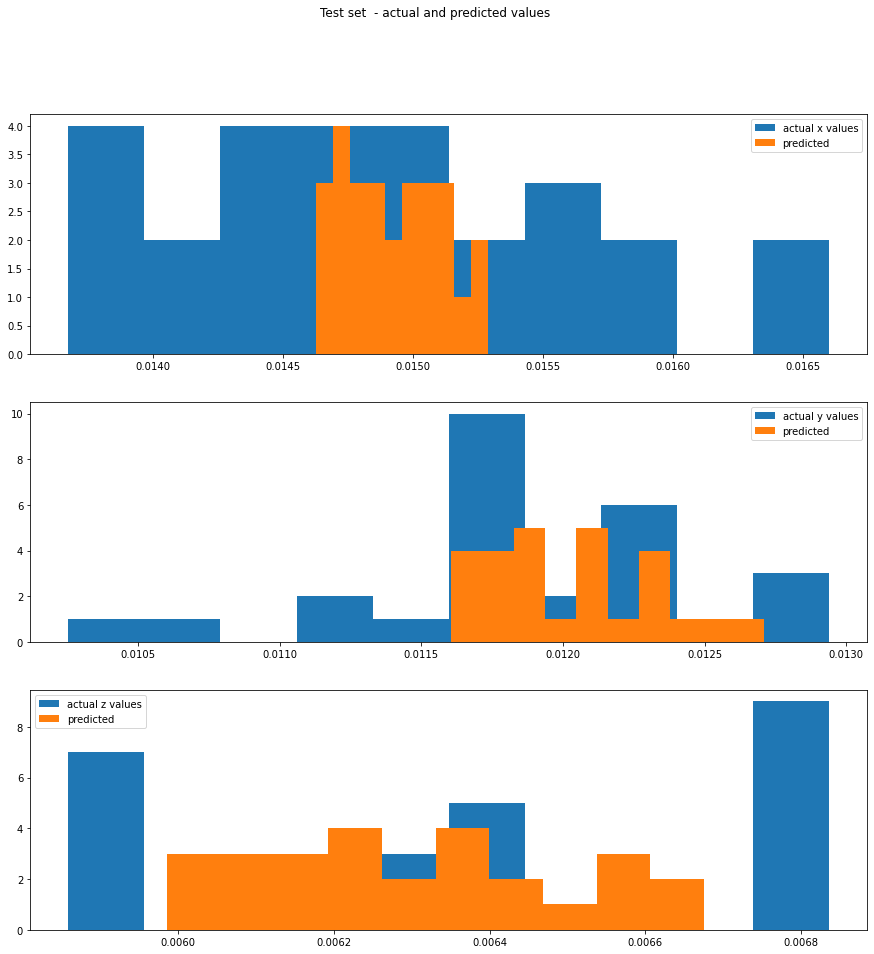

In [72]:
# plot actual Vs predicted values 
plt.figure(figsize = (15,15))
plt.suptitle("Test set  - actual and predicted values")
plt.subplot(3,1,1)
plt.hist(X_test['mad_x'], label = 'actual x values')
plt.hist(pred_test[:,0] , label = 'predicted')
plt.legend()
plt.subplot(3,1,2)
plt.hist(X_test['mad_y'], label = 'actual y values')
plt.hist(pred_test[:,1] , label = 'predicted')
plt.legend()
##
plt.subplot(3,1,3)
plt.hist(X_test['mad_z'], label = 'actual z values')
plt.hist(pred_test[:,2] , label = 'predicted')
plt.legend()

Using the model , check the prediction and MSE for anomaly data.    
The data size is kept same as the test set size .   

In [73]:
# Calculate MSE from anomaly set

anomaly_features = anomaly_features_df[['mad_x','mad_y','mad_z']][:27]
pred_anomaly = model.predict(anomaly_features)
anomaly_mse = np.mean(np.power(anomaly_features - pred_anomaly, 2), axis=1)
print('Average MSE for for anomaly test set:', np.average(anomaly_mse))


Average MSE for for anomaly test set: 8.338976400694789e-06


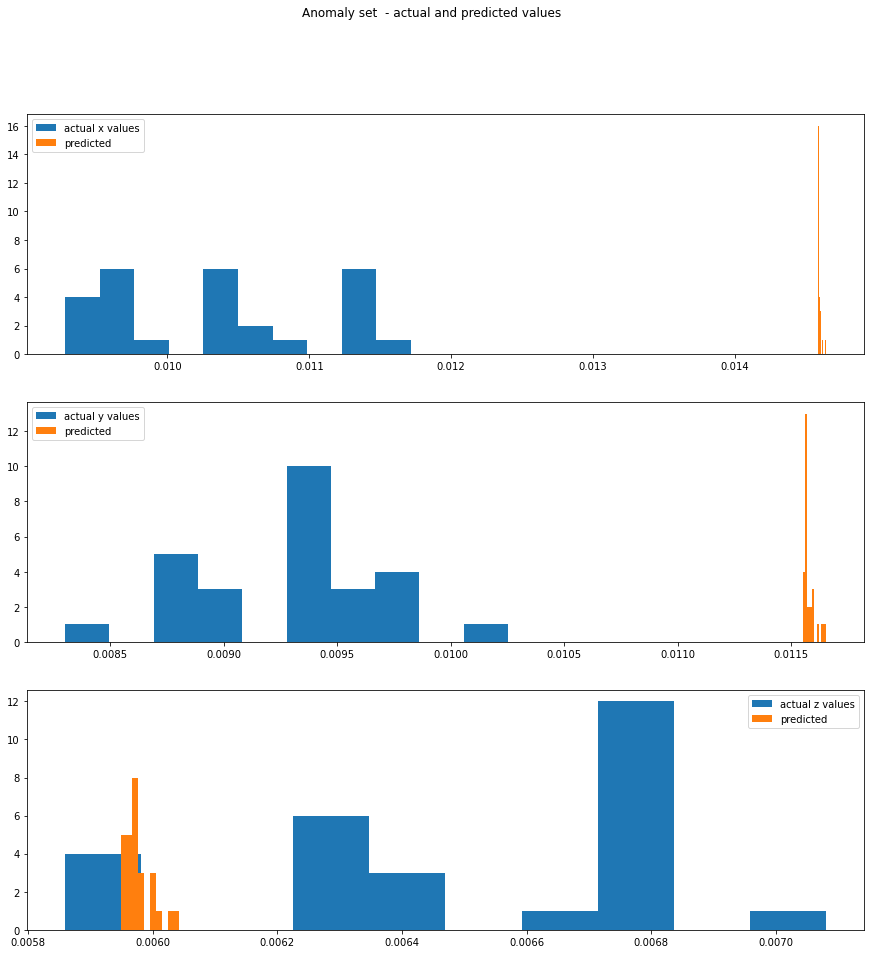

In [74]:
# plot actual Vs predicted values for anomaly
plt.figure(figsize = (15,15))
plt.suptitle("Anomaly set  - actual and predicted values")
plt.subplot(3,1,1)
plt.hist(anomaly_features['mad_x'], label = 'actual x values')
plt.hist(pred_anomaly[:,0] , label = 'predicted')
plt.legend()
plt.subplot(3,1,2)
plt.hist(anomaly_features['mad_y'], label = 'actual y values')
plt.hist(pred_anomaly[:,1] , label = 'predicted')
plt.legend()
##
plt.subplot(3,1,3)
plt.hist(anomaly_features['mad_z'], label = 'actual z values')
plt.hist(pred_anomaly[:,2] , label = 'predicted')
plt.legend()

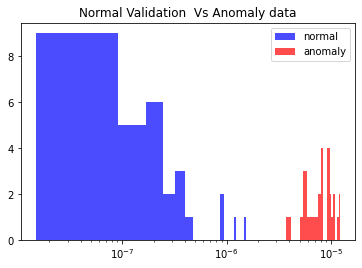

In [75]:
# Plot histograms of normal validation vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mse, bins=20, label='normal', color='blue', alpha=0.7)
ax.hist(anomaly_mse, bins=20, label='anomaly', color='red', alpha=0.7)
plt.title("Normal Validation  Vs Anomaly data")
plt.legend()

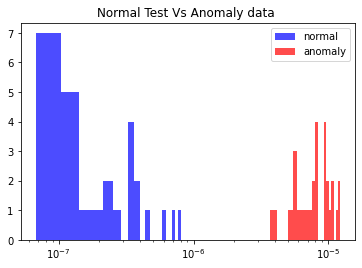

In [76]:
# Plot histograms of normal test vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mse_test, bins=20, label='normal', color='blue', alpha=0.7)
ax.hist(anomaly_mse, bins=20, label='anomaly', color='red', alpha=0.7)
plt.title("Normal Test Vs Anomaly data ")
plt.legend()

In [84]:
# Choose a threshold
anomaly_threshold = 1.381457669586981e-06

In [78]:
#  save the model
model.save("autoencoder_anomaly_detection" + '.h5')

In [87]:
def detect_anomaly(features, model , threshold):
    """
    predict value using the auto encoder model.
    calculate mse.
    if mse > threshold  , mark as anomaly.
    """
    features_reshaped = features.values.reshape(1,3)
    prediction = model.predict(features_reshaped)
    mse = np.mean(np.power(features_reshaped - prediction, 2), axis=1)
    if mse > threshold:
        return 1
    else:
        return 0

In [88]:
y_test_pred = X_test.apply(lambda x: detect_anomaly(x, model, anomaly_threshold), axis = 1)
y_test_pred

93     0
114    0
19     0
69     0
53     0
135    0
126    0
14     0
106    0
112    0
11     0
4      0
105    0
42     0
102    0
110    0
149    0
35     0
123    0
31     0
51     0
75     0
169    0
73     0
40     0
85     0
47     0
dtype: int64

As shown above, the model  has identified  all the normal test set  as 'non-anomaly'.

Check for anomaly records.  

In [93]:
anomaly_pred = anomaly_features[:27].apply(lambda x: detect_anomaly(x, model, anomaly_threshold), axis = 1)
anomaly_pred

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
dtype: int64

Test with a mix of normal features and anomaly features.  
We had retained 25 records of normal_features_df as well as anomaly_features_df of file for this testing.   

In [111]:
normal_features.shape

(175, 3)

In [112]:
all_features = normal_features_df.copy()
all_features = all_features[176:]
all_features.shape

(25, 4)

In [113]:
all_features.tail()

,mad_x,mad_y,mad_z,anomaly
196,0.015137,0.012207,0.006348,0
197,0.015381,0.012696,0.006348,0
198,0.014404,0.011231,0.005859,0
199,0.014648,0.012207,0.006836,0
200,0.016114,0.011719,0.006347,0


In [114]:
anomaly_features_df[176:]

,mad_x,mad_y,mad_z,anomaly
176,0.009277,0.007813,0.006836,1
177,0.009766,0.009766,0.006348,1
178,0.009277,0.008301,0.006348,1
179,0.009765,0.008301,0.007080,1
180,0.009277,0.009277,0.006836,1
181,0.010254,0.009277,0.006348,1
182,0.009765,0.009033,0.006347,1
183,0.008789,0.008301,0.006347,1
184,0.009522,0.008545,0.006348,1
185,0.008789,0.009277,0.006836,1


In [115]:
all_features = all_features.append(anomaly_features_df[176:], ignore_index = True)
all_features.shape

(50, 4)

In [116]:
all_features.tail()

,mad_x,mad_y,mad_z,anomaly
45,0.008301,0.008789,0.006348,1
46,0.009278,0.008301,0.006347,1
47,0.009277,0.008301,0.006348,1
48,0.009765,0.008789,0.006348,1
49,0.009766,0.008789,0.006836,1


Shuffle the  records so that there is a mix of anomaly and  non anomaly.  

In [107]:
all_features = all_features.sample(frac =1)
all_features

,mad_x,mad_y,mad_z,anomaly
9,0.015137,0.011230,0.005860,0
29,0.009277,0.009277,0.006836,1
11,0.015137,0.012207,0.005859,0
47,0.009277,0.008301,0.006348,1
18,0.014404,0.011231,0.006347,0
4,0.015137,0.011719,0.006348,0
38,0.009277,0.008789,0.006836,1
48,0.009765,0.008789,0.006348,1
17,0.014404,0.012207,0.006348,0
5,0.015136,0.011719,0.006348,0


Predict the values of x, y, z based on the model , calculate the mse and check for accuracy of anomaly detection.  

In [108]:
final_test_data = all_features[['mad_x','mad_y','mad_z']]

all_features_pred = final_test_data.apply(lambda x: detect_anomaly(x, model, anomaly_threshold), axis = 1)
all_features_pred

9     0
29    1
11    0
47    1
18    0
4     0
38    1
48    1
17    0
5     0
13    0
1     0
42    1
3     0
15    0
37    1
8     0
2     0
41    1
23    0
31    1
6     0
0     0
43    1
26    1
32    1
35    1
14    0
49    1
12    0
45    1
36    1
10    0
33    1
25    1
46    1
19    0
30    1
34    1
27    1
16    0
22    0
28    1
39    1
40    1
44    1
20    0
21    0
24    0
7     0
dtype: int64

In [109]:
cm = confusion_matrix(all_features['anomaly'], all_features_pred)
cm

array([[25,  0],
       [ 0, 25]])

Text(33.0, 0.5, 'Actual')

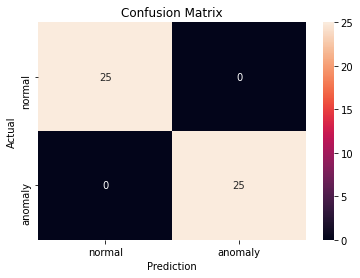

In [110]:
# Plot the confusion matrix.  
df_cm = pd.DataFrame(cm, index=['normal', 'anomaly'], columns=['normal', 'anomaly'])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')